- [Figure 2](#Figure-2)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.stats.qmc import Halton

In [2]:
pd.set_option('display.max_columns', None)

In [110]:
#pip install chardet

Note: you may need to restart the kernel to use updated packages.


In [120]:
#import chardet

#with open(filepath+"pop_2000_2010.csv", "rb") as f:
#   result = chardet.detect(f.read())
#    print(result['encoding'])

ISO-8859-1


In [166]:
filepath = "/Users/nadegelan/Documents/E4S/MGT494/FinalExam/112358-V1/AER_08_APP/"
data1 = pd.read_stata(filepath+"TABLE2/T2_data.dta")
facilities = pd.read_csv(filepath+"facilities.csv") #from 1996-2015, coal as primary fuel type and electric utilities only
emissions = pd.read_csv(filepath+"ozone-emissions.csv")#from CAMPD
data2 = pd.read_stata(filepath+"TABLE_3_4/T_3_4.dta")
pop_2010_2019 = pd.read_csv(filepath+"pop_2010_2019.csv",encoding='ISO-8859-1') #from census.gov
pop_2000_2010 = pd.read_csv(filepath+"pop_2000_2010.csv",encoding='ISO-8859-1')
#age_reg = pd.read_csv(filepath+"AGE_REG.asc",header=None, names=['Age'])
#XMAT = pd.read_csv(filepath+"XMAT_POOL.asc", header=None, delim_whitespace=True)
#XMAT=XMAT.dropna()
#YVEC = pd.read_csv(filepath+"YVEC_POOL.asc", header=None, delim_whitespace=True)
#TIMES = pd.read_csv(filepath+"TIMES_POOL.asc", header=None, delim_whitespace=True)
#DUMMY = pd.read_csv(filepath+"DUMMY_POOL.asc", header=None, delim_whitespace=True)
#XMAT_REG = pd.read_csv(filepath+"XMAT_REG.asc", header=None, delim_whitespace=True)
#YVEC_REG = pd.read_csv(filepath+"YVEC_REG.asc", header=None, delim_whitespace=True)
#TIMES_REG = pd.read_csv(filepath+"TIMES_REG.asc", header=None, delim_whitespace=True)

# Figure 2
************************************************************************
				VARIABLES 							
*************************************************************************
					
- IN_DATA	A dummy indicating whether the unit is included in the analysis
 			(units are excluded if one or more variables are missing).
- FAC_ID	A unique facility identifier
- OWN_ID	A unique owner identifier
- UNIt_ID	A unique boiler identifier
- REGIME	Indicates if the facility is deregulated (1) regulated (2) or public(3)					
- U_CAP		Summer capacity (MW)
- U_SUM_HR	Summer heat rate (kWh/btu)
- U_AGE		Plant age (as of 2000)
- U_SUM_CF	Plant capcity factor
- PRE_RET_	Pre-retrofit NOx emissions rate
					
- D_SCR		Dummy indicating SCR retrofit
- D_SNCR	Dummy indicating SNCR retrofit
- D_LN		Dummy indicating LNB retrofit
- D_CM		Dummy indicating CM retrofit					
- D_NO		Dummy indicating no retrofit

- C_CM		CM retrofit dummy * capacity	
- C_NONE	No retrofit dummy * capacity	
- C_LN		LN retrofit dummy * capacity	
- C_SC		SC retrofit dummy * capacity						
- C_SN	  	SN retrofit dummy * capacity	

- REG		Regulated unit dummy
- PUB		Public dummy
- UNREG		Unregulated unit dummy

**************************************************************************************/

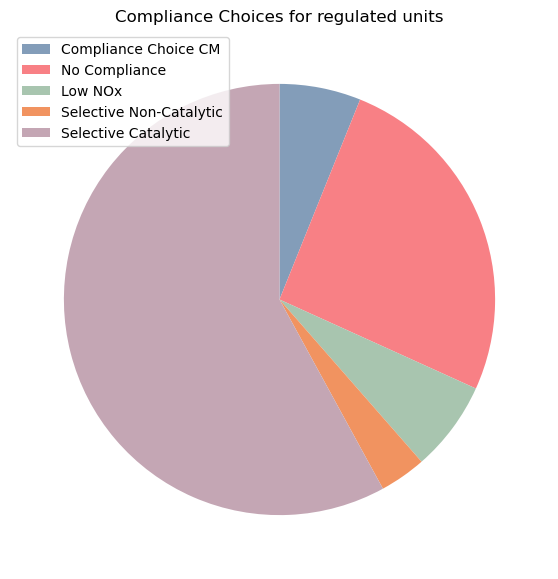

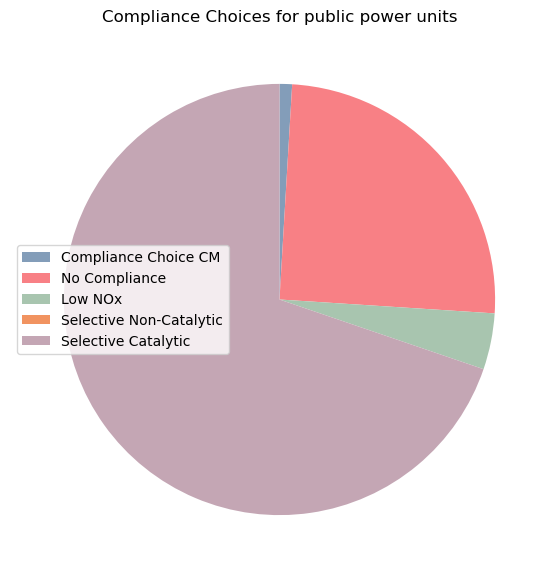

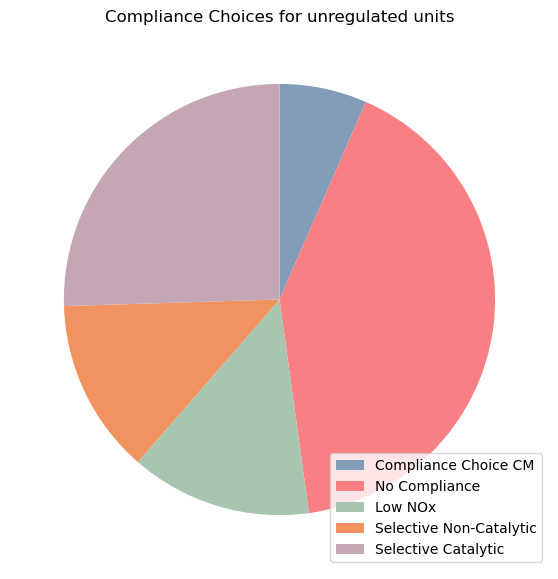

In [51]:
# Generate table for compliance choices by regime
compliance_choices = data1.groupby("REGIME")[["C_CM", "C_NONE", "C_LN", "C_SN", "C_SC"]].sum().reset_index()


def plot_pie_chart(regime,regime_name):
    color_palette = {
    "C_CM": "#839db9",    #Blue
    "C_NONE": "#f88085",  #Pinkish red
    "C_LN": "#a8c5af", #Green 
    "C_SN": "#f19360", #Orange
    "C_SC": "#c4a6b4"    # Purple
    }
    # Filter rows for the current regime
    regime_data = compliance_choices[compliance_choices['REGIME'] == regime]
    
    # Drop the REGIME column and transpose to get a single Series for pie chart
    regime_data = regime_data.drop(columns=['REGIME']).iloc[0]
    
    # Map colors to the columns
    colors = [color_palette[col] for col in regime_data.index]
    
    # Custom labels for the legend
    custom_labels = {
        "C_CM": "Compliance Choice CM",
        "C_NONE": "No Compliance",
        "C_LN": "Low NOx",
        "C_SC": "Selective Catalytic",
        "C_SN": "Selective Non-Catalytic"
    }
    
    
    
    # Plot the pie chart
    plt.figure(figsize=(7, 7))
    regime_data.plot.pie(
        labels=None, 
        startangle=90,
        colors=colors,
        counterclock=False,
        legend=True,
    )
    # Add a custom legend
    plt.legend(
        labels=[custom_labels[col] for col in regime_data.index],  # Custom legend labels
        loc='best'
    )
    # Add title and remove y-label
    plt.title(f"Compliance Choices for {regime_name}")
    plt.ylabel("")# Remove the y-axis label for cleaner look
    plt.show()
    
plot_pie_chart(2,'regulated units')
plot_pie_chart(3,'public power units')
plot_pie_chart(1,'unregulated units')


In [6]:
# Summary statistics for missing data
missing_data_summary = data1.groupby("IN_DATA").agg({
    "U_CAP": ["mean", "count"],
    "U_AGE": ["mean", "count"]
})
print("\nSummary Statistics for Missing Data:")
print(missing_data_summary)


Summary Statistics for Missing Data:
              U_CAP            U_AGE      
               mean count       mean count
IN_DATA                                   
0.0       51.653061    81  21.065790    76
1.0      271.716309   632  36.167721   632


# Table 1

In [7]:
# Filter to include only rows where IN_DATA == 1
filtered_data = data1[data1["IN_DATA"] == 1]

In [54]:
print(filtered_data.groupby("REGIME")[["FAC_ID","OWN_ID","UNIT_ID"]].nunique())

        FAC_ID  OWN_ID  UNIT_ID
REGIME                         
1.0         86      34        8
2.0        100      33        6
3.0         34      15       10


In [57]:
# Summarize capacity and unit age
capacity_age_summary = filtered_data.groupby("REGIME").agg({
    "U_CAP": ["mean", "std"],
    "U_AGE": ["mean", "std"]
}).round(0).astype(int)
print("\nCapacity and Unit Age Summary:")
print(capacity_age_summary)


Capacity and Unit Age Summary:
       U_CAP      U_AGE    
        mean  std  mean std
REGIME                     
1.0      249  212    37  11
2.0      314  279    36  11
3.0      208  227    35  11


In [60]:
# Summarize summer heat rate and pre-retrofit emissions rates
heat_emissions_summary = filtered_data.groupby("REGIME").agg({
    "U_SUM_HR": ["mean", "std"],
    "PRE_RET_MNEMI": ["mean", "std"]
})
heat_emissions_summary[("U_SUM_HR", "mean")] = heat_emissions_summary[("U_SUM_HR", "mean")].round(0).astype(int)
heat_emissions_summary[("U_SUM_HR", "std")] = heat_emissions_summary[("U_SUM_HR", "std")].round(0).astype(int)
heat_emissions_summary[("PRE_RET_MNEMI", "mean")] = heat_emissions_summary[("PRE_RET_MNEMI", "mean")].round(2)
heat_emissions_summary[("PRE_RET_MNEMI", "std")] = heat_emissions_summary[("PRE_RET_MNEMI", "std")].round(2)
print("\nSummer Heat Rate and Pre-Retrofit Emissions Summary:")
print(heat_emissions_summary)


Summer Heat Rate and Pre-Retrofit Emissions Summary:
       U_SUM_HR       PRE_RET_MNEMI      
           mean   std          mean   std
REGIME                                   
1.0       12120  4747          0.48  0.21
2.0       11866  5956          0.54  0.22
3.0       12184  1898          0.55  0.23


In [61]:
# Summarize summer capacity factors
capacity_factors_summary = filtered_data.groupby("REGIME").agg({
    "U_SUM_CF": ["mean", "std"]
}).round(0).astype(int)
print("\nSummer Capacity Factors Summary:")
print(capacity_factors_summary)


Summer Capacity Factors Summary:
       U_SUM_CF    
           mean std
REGIME             
1.0          63  17
2.0          67  14
3.0          68  13


# Table 2

In [72]:
print(data2.shape)
# Create new variables (equivalent to "gen" and "replace" in Stata)
data2['CS_CM'] = np.where(
    (data2['C_CM'] == 1) | (data2['C_OFA'] == 1), 1, 0
)

data2['CS_LN'] = np.where(
    (data2['C_LNC1'] == 1) | (data2['C_LNC2'] == 1) |
    (data2['C_LNC3'] == 1) | (data2['C_LNB'] == 1) |
    (data2['C_LNBO'] == 1), 1, 0
)

data2['CHOICE'] = (
    data2['C_CM_LNC1'] + data2['C_CM'] + data2['C_LNC1'] +
    data2['C_LNC2'] + data2['C_LNC3'] + data2['C_LNC3_SCR'] +
    data2['C_LNB'] + data2['C_LNBO'] + data2['C_LOSC'] +
    data2['C_NONE'] + data2['C_OFA'] + data2['C_OSNCR'] +
    data2['C_SCR'] + data2['C_SNCR']
)

# Group by REGIME and compute summary statistics
#table_2 = data2.groupby('REGIME').agg(
    #CHOICE_mean=('CHOICE', 'mean'),
    #CHOICE_sd=('CHOICE', 'std'),
    #C_SCR_mean=('C_SCR', 'mean'),
    #C_SNCR_mean=('C_SNCR', 'mean'),
    #CS_CM_mean=('CS_CM', 'mean'),
    #CS_LN_mean=('CS_LN', 'mean')
#).reset_index()

#print("Table 2 Summary Statistics:")
#print(table_2)

# Keep only relevant columns for Table 3
#columns_to_keep = ['V1', 'F', 'TECH', 'TECH_FINAL', 'REG', 'UNREG', 'PUB', 'REGIME']
#tables_3_4_data_filtered = tables_3_4_data[columns_to_keep]

# Filter data for specific TECH_FINAL values
#tables_3_4_data_filtered = tables_3_4_data_filtered[tables_3_4_data_filtered['TECH_FINAL'].isin(["CM", "LNB", "N", "SC", "SN"])]

# ********* Table 2 *********
# Group by REGIME and TECH_FINAL and compute summary statistics
table_2 = data2.groupby(['REGIME', 'TECH_FINAL']).agg(
    F_mean=('F', 'mean'),
    F_sd=('F', 'std'),
    V1_mean=('V1', 'mean'),
    V1_sd=('V1', 'std')
).reset_index()

table_2=table_2[table_2['TECH_FINAL'].isin(['CM','LNB','SN','SC','N'])]
table_2['F_mean']=table_2['F_mean'].round(2)
table_2['F_sd']=table_2['F_sd'].round(2)
table_2['V1_mean']=(table_2['V1_mean']*100).round(2)
table_2['V1_sd']=(table_2['V1_sd']*100).round(2)
print("Table 2 Summary Statistics:")
print(table_2)

(5036, 26)
Table 2 Summary Statistics:
    REGIME TECH_FINAL     F_mean   F_sd  V1_mean  V1_sd
1      1.0         CM  12.630000   4.19     0.91   0.38
6      1.0        LNB  19.100000   5.89     0.83   0.30
9      1.0          N   0.000000   0.00     1.25   0.58
13     1.0         SC  71.209999  22.17     0.53   0.35
14     1.0         SN  17.360001  14.45     0.95   0.42
16     2.0         CM  12.460000   5.02     1.05   0.39
21     2.0        LNB  17.200001   3.16     0.86   0.23
24     2.0          N   0.000000   0.00     1.34   0.57
28     2.0         SC  68.379997  19.92     0.51   0.16
29     2.0         SN  15.690000  14.59     1.02   0.38
31     3.0         CM  11.850000   4.25     1.08   0.38
36     3.0        LNB  18.790001   4.20     0.85   0.21
39     3.0          N   0.000000   0.00     1.50   0.67
43     3.0         SC  81.010002  30.90     0.59   0.22
44     3.0         SN  25.240000  30.85     1.07   0.37


# Table 3

In [83]:
data2['TECH_FINAL'].unique

,REG,PUB,UNREG,REGIME,TECH_FINAL,F,V1,n,C_CM,C_OFA,C_LNB,C_LNBO,C_SCR,C_SNCR,C_OSCR,C_LOSC,C_NONE,C_LNC1,C_LNC2,C_LNC3,C_CM_LNC1,C_LNC3_SCR,C_OSNCR,CS_CM,CS_LN,CHOICE
0,1.0,0.0,0.0,2.0,L3S,63.779999,0.004852,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1,1,9.0
1,1.0,0.0,0.0,2.0,CM,10.500000,0.017411,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1,1,9.0
2,1.0,0.0,0.0,2.0,SC,48.139999,0.005254,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1,1,9.0
3,1.0,0.0,0.0,2.0,L2,14.300000,0.013253,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1,1,9.0
4,1.0,0.0,0.0,2.0,N,0.000000,0.021794,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1,1,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5031,0.0,0.0,1.0,1.0,N,0.000000,0.008947,724.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1,1,8.0
5032,0.0,0.0,1.0,1.0,SC,51.950001,0.003935,724.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1,1,8.0
5033,0.0,0.0,1.0,1.0,L2,19.500000,0.006516,724.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1,1,8.0
5034,0.0,0.0,1.0,1.0,L3,26.100000,0.006068,724.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1,1,8.0


In [91]:
data2
table_3 = data2.groupby('REGIME').agg(
    number_choices=('CHOICE','mean'),
    number_choices_sd = ('CHOICE','std'),
    CM = ('C_CM','sum'),
    OFA = ('C_OFA','sum')
).round(1).reset_index()
#print(data2[data2['TECH_FINAL']=='CM']['C_CM'].sum())
table_3['CM_OFA_pct']=(table_3['CM']+table_3['OFA'])/5036
print(table_3)

   REGIME  number_choices  number_choices_sd      CM     OFA  CM_OFA_pct
0     1.0             6.7                1.8  1526.0   729.0    0.447776
1     2.0             6.4                1.9  1722.0  1093.0    0.558975
2     3.0             6.3                1.9   774.0   601.0    0.273034


# Extension

Your extension—investigating whether the NOx Budget Program (NBP) was successful overall by examining its impact on NOx emissions using an OLS framework—is a valid and meaningful addition to the literature. The original paper by Fowlie focused on compliance choices under different regulatory regimes, which is a micro-level analysis of how market regulation shapes behavior. Your extension takes a complementary macro-level perspective, looking at the overall environmental effectiveness of the program in reducing NOx emissions.
Motivation for Your Extension

Policy Evaluation Beyond Compliance Choices:
While Fowlie’s analysis of compliance choices helps us understand how regulations influence behavior, the ultimate goal of such programs is to reduce emissions. By directly assessing the impact of NBP on emissions, your work evaluates whether the program achieved its primary objective.

Public Policy Relevance:
Policymakers and stakeholders need evidence of program effectiveness to justify past policies and guide future decisions. Your analysis addresses this need by providing empirical evidence on whether the NBP delivered tangible environmental benefits.

Broadening the Scope:
Fowlie’s paper focuses on the interaction of regulation and market dynamics. By shifting the focus to overall program effectiveness, you address a different but equally important research question: Does participation in market-based programs like the NBP result in measurable emissions reductions at a macro level?

Strengths of Your Approach

Inclusion of Key Covariates:
Your model includes essential factors influencing emissions, such as heat input (a proxy for energy production), gross load, and population. These variables control for changes in emissions driven by energy demand, technological changes, and demographic shifts.

Quantifying NBP’s Effectiveness:
The use of a dummy variable for NBP participation isolates the program's impact on emissions, providing a clear measure of its effectiveness.

Integration of ARP:
By including an ARP dummy, your model accounts for overlapping regulatory influences, ensuring that the estimated effect of NBP is not confounded by concurrent programs.

Suggestions for Improvement or Extensions

Regulatory Regime Interaction:
Consider segmenting your analysis by regulatory regimes (regulated, deregulated, and public units). This segmentation aligns your work more closely with Fowlie’s framework and allows you to explore whether NBP’s effectiveness varies by regulatory environment.

Temporal Effects:
Add interaction terms for NBP_Dummy and Year_Trend to capture whether NBP’s impact on emissions strengthened or weakened over time. This could reveal whether compliance costs or technological adoption played a role in the program's evolving effectiveness.

Inclusion of Unit Characteristics:
If data is available, include unit-level variables such as fuel type, technology type, and control technologies (e.g., SCR, SNCR). These characteristics directly influence emissions and could strengthen your model’s explanatory power.

Spatial Effects:
Explore spatial spillover effects by incorporating regional or state-level fixed effects. This addition would control for regional policies, economic conditions, or geographic factors influencing emissions.

Heterogeneous Treatment Effects:
Investigate whether NBP’s impact differs for specific types of facilities (e.g., size, ownership type, baseline emissions levels). This analysis could uncover insights into which facilities benefited most from the program.

Robustness Checks:
Test your results under different specifications (e.g., alternative functional forms, dropping outliers, using alternative measures of program participation). Robustness checks strengthen the validity of your findings.

Counterfactual Analysis:
If feasible, incorporate a difference-in-differences approach to compare emissions trends between participating and non-participating units before and after the program's implementation.

Conclusion

Your extension is well-motivated and fills an important gap in the literature by evaluating the environmental effectiveness of the NBP. However, incorporating the suggestions above could significantly enhance the depth and robustness of your analysis. By extending your model to account for regulatory regimes, temporal dynamics, unit characteristics, and spatial effects, you would generate richer insights and a more comprehensive evaluation of the NBP’s success. Let me know if you'd like help implementing any of these ideas!

In [172]:
facilities = pd.read_csv(filepath+"facilities.csv")

In [129]:
pop_2000_2010

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,ESTIMATESBASE2000,POPESTIMATE2000,POPESTIMATE2001,POPESTIMATE2002,POPESTIMATE2003,POPESTIMATE2004,POPESTIMATE2005,POPESTIMATE2006,POPESTIMATE2007,POPESTIMATE2008,POPESTIMATE2009,CENSUS2010POP,POPESTIMATE2010
0,40,3,6,1,0,Alabama,Alabama,4447207,4452173,4467634,4480089,4503491,4530729,4569805,4628981,4672840,4718206,4757938,4779736,4785298
1,50,3,6,1,1,Alabama,Autauga County,43751,44021,44889,45909,46800,48366,49676,51328,52405,53277,54135,54571,54632
2,50,3,6,1,3,Alabama,Baldwin County,140416,141342,144875,147957,151509,156266,162183,168121,172404,175827,179406,182265,183195
3,50,3,6,1,5,Alabama,Barbour County,29042,29015,28863,28653,28594,28287,28027,27861,27757,27808,27657,27457,27411
4,50,3,6,1,7,Alabama,Bibb County,19856,19913,21028,21199,21399,21721,22042,22099,22438,22705,22941,22915,22867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3189,50,4,8,56,37,Wyoming,Sweetwater County,37620,37552,36899,37428,37450,38026,38739,39749,41470,42358,44133,43806,43621
3190,50,4,8,56,39,Wyoming,Teton County,18257,18381,18653,18837,19066,19467,19632,20014,20472,20988,21232,21294,21302
3191,50,4,8,56,41,Wyoming,Uinta County,19745,19666,19413,19587,19480,19470,19494,19709,20171,20613,21054,21118,21137
3192,50,4,8,56,43,Wyoming,Washakie County,8292,8252,8068,7988,7976,7960,8022,7979,8169,8229,8423,8533,8556


In [131]:
# Reshape the data into long format
#pop2000_2010 = pd.melt(
    #pop_2000_2010,
    #id_vars=['SUMLEV', 'REGION', 'DIVISION', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME'],  # Columns to keep
    #value_vars=[
        #'POPESTIMATE2000', 'POPESTIMATE2001', 'POPESTIMATE2002', 'POPESTIMATE2003',
        #'POPESTIMATE2004', 'POPESTIMATE2005', 'POPESTIMATE2006', 'POPESTIMATE2007',
        #'POPESTIMATE2008', 'POPESTIMATE2009', 'CENSUS2010POP', 'POPESTIMATE2010'
    #],  # Columns to unpivot
    #var_name='Year',  # New column to store years
    #value_name='Population'  # New column to store population estimates
#)

# Extract the year from the column names (e.g., 'POPESTIMATE2000' -> 2000, 'CENSUS2010POP' -> 2010)
#pop2000_2010['Year'] = pop2000_2010['Year'].str.extract('(\d{4})')

# Convert Year to an integer
#pop2000_2010['Year'] = pop2000_2010['Year'].astype(int)

# Display the transformed DataFrame
#print(pop2000_2010.head())

# Save to a new CSV file (optional)
#pop2000_2010.to_csv('pop_2000_2010.csv', index=False)


   SUMLEV  REGION  DIVISION  STATE  COUNTY   STNAME         CTYNAME  Year  \
0      40       3         6      1       0  Alabama         Alabama  2000   
1      50       3         6      1       1  Alabama  Autauga County  2000   
2      50       3         6      1       3  Alabama  Baldwin County  2000   
3      50       3         6      1       5  Alabama  Barbour County  2000   
4      50       3         6      1       7  Alabama     Bibb County  2000   

   Population  
0     4452173  
1       44021  
2      141342  
3       29015  
4       19913  


In [139]:
pop2000_2010 = pd.read_csv('pop_2000_2010.csv')
pop2000_2009 = pop2000_2010[pop2000_2010['Year']!=2010]

In [130]:
#Reshape the data into long format

#pop_2010_2015 = pd.melt(
    #pop_2010_2019,
    #id_vars=['SUMLEV', 'REGION', 'DIVISION', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME'],  # Columns to keep
    #value_vars=['POPESTIMATE2010', 'POPESTIMATE2011', 'POPESTIMATE2012', 'POPESTIMATE2013','POPESTIMATE2014', 'POPESTIMATE2015'],  # Columns to unpivot
    #var_name='Year',  # New column to store years
    #value_name='Population'  # New column to store population estimates
#)

#Extract the year from the column names (e.g., 'POPESTIMATE2010' -> 2010)
#pop_2010_2015['Year'] = pop_2010_2015['Year'].str.extract('(\d{4})')

#Convert Year to an integer
#pop_2010_2015['Year'] = pop_2010_2015['Year'].astype(int)

#Display the transformed DataFrame
#print(pop_2010_2015.head())

#Save to a new CSV file (optional)
#pop_2010_2015.to_csv('pop_2010_2015.csv', index=False)


In [134]:
pop2010_2015=pd.read_csv('pop_2010_2015.csv')
pop2010_2015

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,Year,Population
0,40,3,6,1,0,Alabama,Alabama,2010,4785437
1,50,3,6,1,1,Alabama,Autauga County,2010,54773
2,50,3,6,1,3,Alabama,Baldwin County,2010,183112
3,50,3,6,1,5,Alabama,Barbour County,2010,27327
4,50,3,6,1,7,Alabama,Bibb County,2010,22870
...,...,...,...,...,...,...,...,...,...
19153,50,4,8,56,37,Wyoming,Sweetwater County,2015,44719
19154,50,4,8,56,39,Wyoming,Teton County,2015,23047
19155,50,4,8,56,41,Wyoming,Uinta County,2015,20763
19156,50,4,8,56,43,Wyoming,Washakie County,2015,8278


In [159]:
pop = pd.concat([pop2000_2009, pop2010_2015], ignore_index=True)

In [173]:
state_abbreviation_to_number = {
    'AL': 1, 'AK': 2, 'AZ': 4, 'AR': 5, 'CA': 6, 'CO': 8, 'CT': 9, 
    'DE': 10, 'FL': 12, 'GA': 13, 'HI': 15, 'ID': 16, 'IL': 17, 
    'IN': 18, 'IA': 19, 'KS': 20, 'KY': 21, 'LA': 22, 'ME': 23, 
    'MD': 24, 'MA': 25, 'MI': 26, 'MN': 27, 'MS': 28, 'MO': 29, 
    'MT': 30, 'NE': 31, 'NV': 32, 'NH': 33, 'NJ': 34, 'NM': 35, 
    'NY': 36, 'NC': 37, 'ND': 38, 'OH': 39, 'OK': 40, 'OR': 41, 
    'PA': 42, 'RI': 44, 'SC': 45, 'SD': 46, 'TN': 47, 'TX': 48, 
    'UT': 49, 'VT': 50, 'VA': 51, 'WA': 53, 'WV': 54, 'WI': 55, 
    'WY': 56, 'DC': 11
}
facilities['STATE']= facilities['State'].map(state_abbreviation_to_number)
facilities.rename(columns={'FIPS Code':'COUNTY'},inplace=True)
facilities['STATE']=facilities['STATE'].fillna(-1)
facilities['STATE']=facilities['STATE'].astype(int)

In [175]:
facilities

,State,Facility Name,Facility ID,Unit ID,Associated Stacks,Year,Program Code,Primary Rep Info,EPA Region,NERC Region,County,County Code,COUNTY,Source Category,Latitude,Longitude,Owner/Operator,SO2 Phase,NOx Phase,Unit Type,Primary Fuel Type,Secondary Fuel Type,SO2 Controls,NOx Controls,PM Controls,Hg Controls,Commercial Operation Date,Operating Status,Max Hourly HI Rate (mmBtu/hr),Associated Generators & Nameplate Capacity (MWe),STATE
0,AL,Barry,3,1,CS0AAN,1996,ARP,83,4,SERC,Mobile County,AL097,97,Electric Utility,31.0069,-88.0103,NaN,Phase 2,NaN,Tangentially-fired,Coal,"Diesel Oil, Pipeline Natural Gas",NaN,NaN,Electrostatic Precipitator,NaN,1954-02-12,Operating,NaN,1 (153.1),1
1,AL,Barry,3,1,CS0AAN,1997,ARP,"83 (Ended Dec 07, 1997), 900 (Started Dec 08, ...",4,SERC,Mobile County,AL097,97,Electric Utility,31.0069,-88.0103,NaN,Phase 2,NaN,Tangentially-fired,Coal,"Diesel Oil, Pipeline Natural Gas",NaN,NaN,Electrostatic Precipitator,NaN,1954-02-12,Operating,NaN,1 (153.1),1
2,AL,Barry,3,1,CS0AAN,1998,ARP,"900 (Ended May 26, 1998), 975 (Started May 27,...",4,SERC,Mobile County,AL097,97,Electric Utility,31.0069,-88.0103,NaN,Phase 2,NaN,Tangentially-fired,Coal,"Diesel Oil, Pipeline Natural Gas",NaN,NaN,Electrostatic Precipitator,NaN,1954-02-12,Operating,NaN,1 (153.1),1
3,AL,Barry,3,1,CS0AAN,1999,ARP,975,4,SERC,Mobile County,AL097,97,Electric Utility,31.0069,-88.0103,NaN,Phase 2,NaN,Tangentially-fired,Coal,"Diesel Oil, Pipeline Natural Gas",NaN,NaN,Electrostatic Precipitator,NaN,1954-02-12,Operating,NaN,1 (153.1),1
4,AL,Barry,3,1,CS0AAN,2000,ARP,975,4,SERC,Mobile County,AL097,97,Electric Utility,31.0069,-88.0103,Alabama Power Company (Operator),Phase 2,Phase 2 Group 1,Tangentially-fired,Coal,"Diesel Oil, Pipeline Natural Gas",NaN,NaN,Electrostatic Precipitator,NaN,1954-02-12,Operating,NaN,1 (153.1),1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21225,VA,Virginia City Hybrid Energy Center,56808,2,NaN,2013,"ARP, CAIRNOX, CAIROS, CAIRSO2","603957 (Ended Jun 28, 2013), 606670 (Started J...",3,NaN,Wise County,VA195,195,Electric Utility,36.9161,-82.3381,Virginia Electric & Power Company (Owner)|Domi...,Phase 2,NaN,Circulating fluidized bed boiler,Coal,"Coal Refuse, Wood",Dry Lime FGD|Fluidized Bed Limestone Injection,Selective Non-catalytic Reduction,Baghouse,NaN,2012-03-07,Operating,3300.0,1 (668),51
21226,VA,Virginia City Hybrid Energy Center,56808,2,NaN,2014,"ARP, CAIRNOX, CAIROS, CAIRSO2",606670,3,NaN,Wise County,VA195,195,Electric Utility,36.9161,-82.3381,Virginia Electric & Power Company (Owner)|Domi...,Phase 2,NaN,Circulating fluidized bed boiler,Coal,"Coal Refuse, Wood",Dry Lime FGD|Fluidized Bed Limestone Injection,Selective Non-catalytic Reduction,Baghouse,NaN,2012-03-07,Operating,3300.0,1 (668),51
21227,VA,Virginia City Hybrid Energy Center,56808,2,NaN,2015,"ARP, CSNOX, CSNOXOS, CSSO2G1, MATS","606670 (Ended Mar 26, 2015), 607952 (Started J...",3,NaN,Wise County,VA195,195,Electric Utility,36.9161,-82.3381,Virginia Electric & Power Company (Owner)|Domi...,Phase 2,NaN,Circulating fluidized bed boiler,Coal,"Coal Refuse, Wood",Dry Lime FGD|Fluidized Bed Limestone Injection,Selective Non-catalytic Reduction,Baghouse,NaN,2012-03-07,Operating,3300.0,1 (668),51
21228,PR,"AES Puerto Rico, LP",880102,1,NaN,2015,MATS,"607769 (Started Feb 04, 2015)",2,NaN,Guayama Municipio,PR057,57,Electric Utility,17.9477,-66.1540,"AES Puerto Rico (Owner) (Started Feb 04, 2015)...",NaN,NaN,Circulating fluidized bed boiler,Coal,NaN,Dry Lime FGD,Selective Non-catalytic Reduction,Electrostatic Precipitator,NaN,2002-11-29,Operating,2461.0,1 (260),-1


In [176]:
fac_with_pop = pd.merge(
    facilities,
    pop,
    left_on=['STATE', 'COUNTY','County','Year'],
    right_on=['STATE', 'COUNTY','CTYNAME','Year'],
    how='left'  #retain all rows in facilities
)
fac_with_pop

,State,Facility Name,Facility ID,Unit ID,Associated Stacks,Year,Program Code,Primary Rep Info,EPA Region,NERC Region,County,County Code,COUNTY,Source Category,Latitude,Longitude,Owner/Operator,SO2 Phase,NOx Phase,Unit Type,Primary Fuel Type,Secondary Fuel Type,SO2 Controls,NOx Controls,PM Controls,Hg Controls,Commercial Operation Date,Operating Status,Max Hourly HI Rate (mmBtu/hr),Associated Generators & Nameplate Capacity (MWe),STATE,SUMLEV,REGION,DIVISION,STNAME,CTYNAME,Population
0,AL,Barry,3,1,CS0AAN,1996,ARP,83,4,SERC,Mobile County,AL097,97,Electric Utility,31.0069,-88.0103,NaN,Phase 2,NaN,Tangentially-fired,Coal,"Diesel Oil, Pipeline Natural Gas",NaN,NaN,Electrostatic Precipitator,NaN,1954-02-12,Operating,NaN,1 (153.1),1,NaN,NaN,NaN,NaN,NaN,NaN
1,AL,Barry,3,1,CS0AAN,1997,ARP,"83 (Ended Dec 07, 1997), 900 (Started Dec 08, ...",4,SERC,Mobile County,AL097,97,Electric Utility,31.0069,-88.0103,NaN,Phase 2,NaN,Tangentially-fired,Coal,"Diesel Oil, Pipeline Natural Gas",NaN,NaN,Electrostatic Precipitator,NaN,1954-02-12,Operating,NaN,1 (153.1),1,NaN,NaN,NaN,NaN,NaN,NaN
2,AL,Barry,3,1,CS0AAN,1998,ARP,"900 (Ended May 26, 1998), 975 (Started May 27,...",4,SERC,Mobile County,AL097,97,Electric Utility,31.0069,-88.0103,NaN,Phase 2,NaN,Tangentially-fired,Coal,"Diesel Oil, Pipeline Natural Gas",NaN,NaN,Electrostatic Precipitator,NaN,1954-02-12,Operating,NaN,1 (153.1),1,NaN,NaN,NaN,NaN,NaN,NaN
3,AL,Barry,3,1,CS0AAN,1999,ARP,975,4,SERC,Mobile County,AL097,97,Electric Utility,31.0069,-88.0103,NaN,Phase 2,NaN,Tangentially-fired,Coal,"Diesel Oil, Pipeline Natural Gas",NaN,NaN,Electrostatic Precipitator,NaN,1954-02-12,Operating,NaN,1 (153.1),1,NaN,NaN,NaN,NaN,NaN,NaN
4,AL,Barry,3,1,CS0AAN,2000,ARP,975,4,SERC,Mobile County,AL097,97,Electric Utility,31.0069,-88.0103,Alabama Power Company (Operator),Phase 2,Phase 2 Group 1,Tangentially-fired,Coal,"Diesel Oil, Pipeline Natural Gas",NaN,NaN,Electrostatic Precipitator,NaN,1954-02-12,Operating,NaN,1 (153.1),1,50.0,3.0,6.0,Alabama,Mobile County,400073.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21225,VA,Virginia City Hybrid Energy Center,56808,2,NaN,2013,"ARP, CAIRNOX, CAIROS, CAIRSO2","603957 (Ended Jun 28, 2013), 606670 (Started J...",3,NaN,Wise County,VA195,195,Electric Utility,36.9161,-82.3381,Virginia Electric & Power Company (Owner)|Domi...,Phase 2,NaN,Circulating fluidized bed boiler,Coal,"Coal Refuse, Wood",Dry Lime FGD|Fluidized Bed Limestone Injection,Selective Non-catalytic Reduction,Baghouse,NaN,2012-03-07,Operating,3300.0,1 (668),51,50.0,3.0,5.0,Virginia,Wise County,40662.0
21226,VA,Virginia City Hybrid Energy Center,56808,2,NaN,2014,"ARP, CAIRNOX, CAIROS, CAIRSO2",606670,3,NaN,Wise County,VA195,195,Electric Utility,36.9161,-82.3381,Virginia Electric & Power Company (Owner)|Domi...,Phase 2,NaN,Circulating fluidized bed boiler,Coal,"Coal Refuse, Wood",Dry Lime FGD|Fluidized Bed Limestone Injection,Selective Non-catalytic Reduction,Baghouse,NaN,2012-03-07,Operating,3300.0,1 (668),51,50.0,3.0,5.0,Virginia,Wise County,39892.0
21227,VA,Virginia City Hybrid Energy Center,56808,2,NaN,2015,"ARP, CSNOX, CSNOXOS, CSSO2G1, MATS","606670 (Ended Mar 26, 2015), 607952 (Started J...",3,NaN,Wise County,VA195,195,Electric Utility,36.9161,-82.3381,Virginia Electric & Power Company (Owner)|Domi...,Phase 2,NaN,Circulating fluidized bed boiler,Coal,"Coal Refuse, Wood",Dry Lime FGD|Fluidized Bed Limestone Injection,Selective Non-catalytic Reduction,Baghouse,NaN,2012-03-07,Operating,3300.0,1 (668),51,50.0,3.0,5.0,Virginia,Wise County,39572.0
21228,PR,"AES Puerto Rico, LP",880102,1,NaN,2015,MATS,"607769 (Started Feb 04, 2015)",2,NaN,Guayama Municipio,PR057,57,Electric Utility,17.9477,-66.1540,"AES Puerto Rico (Owner) (Started Feb 04, 2015)...",NaN,NaN,Circulating fluidized bed boiler,Coal,NaN,Dry Lime FGD,Selective Non-catalytic Reduction,Electrostatic Precipitator,NaN,2002-11-29,Operating,2461.0,1 (260)

In [178]:
emissions_with_pop = pd.merge(
    fac_with_pop[['State','Facility Name','Facility ID','Unit ID','Year','Source Category','Population']],
    emissions,
    left_on=['State','Facility Name','Facility ID','Unit ID','Year'],
    right_on=['State','Facility Name','Facility ID','Unit ID','Year'],
    how='right'
)
emissions_with_pop['NBP_Dummy']=emissions_with_pop['Program Code'].str.contains('NBP').astype(int)
emissions_with_pop

,State,Facility Name,Facility ID,Unit ID,Year,Source Category,Population,Associated Stacks,Operating Time Count,Sum of the Operating Time,Gross Load (MWh),Steam Load (1000 lb),SO2 Mass (short tons),SO2 Rate (lbs/mmBtu),CO2 Mass (short tons),CO2 Rate (short tons/mmBtu),NOx Mass (short tons),NOx Rate (lbs/mmBtu),Heat Input (mmBtu),Primary Fuel Type,Secondary Fuel Type,Unit Type,SO2 Controls,NOx Controls,PM Controls,Hg Controls,Program Code
0,AL,Barry,3,1,1997,Electric Utility,NaN,CS0AAN,3560.0,3555.25,469836.00,NaN,3071.606,1.3647,461965.920,0.103,1069.784,0.4799,4502401.685,Coal,"Diesel Oil, Pipeline Natural Gas",Tangentially-fired,NaN,NaN,Electrostatic Precipitator,NaN,ARP
1,AL,Barry,3,1,1998,Electric Utility,NaN,CS0AAN,3045.0,3040.50,414353.75,NaN,2394.797,1.2617,389871.672,0.103,893.561,0.4731,3799761.158,Coal,"Diesel Oil, Pipeline Natural Gas",Tangentially-fired,NaN,NaN,Electrostatic Precipitator,NaN,ARP
2,AL,Barry,3,1,1999,Electric Utility,NaN,CS0AAN,3641.0,3640.00,480477.25,NaN,2728.348,1.1802,473946.150,0.103,1261.504,0.5499,4619140.260,Coal,"Diesel Oil, Pipeline Natural Gas",Tangentially-fired,NaN,NaN,Electrostatic Precipitator,NaN,ARP
3,AL,Barry,3,1,2000,Electric Utility,400073.0,CS0AAN,3590.0,3587.75,443298.00,NaN,2508.911,1.1173,458696.982,0.103,1047.781,0.4725,4470516.791,Coal,"Diesel Oil, Pipeline Natural Gas",Tangentially-fired,NaN,NaN,Electrostatic Precipitator,NaN,ARP
4,AL,Barry,3,1,2001,Electric Utility,400129.0,CS0AAN,3541.0,3540.50,449501.75,NaN,2745.127,1.2257,458821.597,0.103,1069.962,0.4849,4471720.396,Coal,"Diesel Oil, Pipeline Natural Gas",Tangentially-fired,NaN,NaN,Electrostatic Precipitator,NaN,ARP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22860,IN,"Noble Americas South Bend Ethanol, LLC.",880087,U-4000,2012,NaN,NaN,NaN,2321.0,2283.37,NaN,367097.29,NaN,NaN,NaN,NaN,80.614,0.3920,419630.447,Coal,Pipeline Natural Gas,Other boiler,NaN,Low NOx Burner Technology (Dry Bottom only),Baghouse,NaN,CAIROS
22861,IN,"Noble Americas South Bend Ethanol, LLC.",880087,U-4000,2013,NaN,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Coal,Pipeline Natural Gas,Other boiler,NaN,Low NOx Burner Technology (Dry Bottom only),Baghouse,NaN,NaN
22862,IN,"Noble Americas South Bend Ethanol, LLC.",880087,U-4000,2014,NaN,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Coal,Pipeline Natural Gas,Other boiler,NaN,Low NOx Burner Technology (Dry Bottom only),Baghouse,NaN,NaN
22863,PR,"AES Puerto Rico, LP",880102,1,2015,Electric Utility,NaN,NaN,2075.0,2073.97,523921.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Coal,NaN,Circulating fluidized bed boiler,Dry Lime FGD,Selective Non-catalytic Reduction,Electrostatic Precipitator,NaN,MATS


In [179]:
emissions_with_pop.isnull().sum()

State                              0
Facility Name                      0
Facility ID                        0
Unit ID                            0
Year                               0
Source Category                 2683
Population                      6282
Associated Stacks              13920
Operating Time Count             104
Sum of the Operating Time        104
Gross Load (MWh)                4704
Steam Load (1000 lb)           18946
SO2 Mass (short tons)           2814
SO2 Rate (lbs/mmBtu)            2822
CO2 Mass (short tons)           2987
CO2 Rate (short tons/mmBtu)     3009
NOx Mass (short tons)            809
NOx Rate (lbs/mmBtu)            1100
Heat Input (mmBtu)              1069
Primary Fuel Type                 22
Secondary Fuel Type            12705
Unit Type                          0
SO2 Controls                   15690
NOx Controls                    5599
PM Controls                      286
Hg Controls                    22422
Program Code                     168
d

In [181]:
from linearmodels.panel import PanelOLS

# Load your data
data = emissions_with_pop

data['Program Code'] = data['Program Code'].fillna('')
# Create dummies for programs
data['NBP_Dummy'] = data['Program Code'].str.contains('NBP').astype(int)
data['ARP_Dummy'] = data['Program Code'].str.contains('ARP').astype(int)

# Create a time trend variable
data['Year_Trend'] = data['Year'] - data['Year'].min()

columns_to_keep = [
    'Facility ID','Facility Name', 'Unit ID','Year','State', 'Program Code', 'NBP_Dummy', 
    'ARP_Dummy', 'Year_Trend', 'NOx Mass (short tons)', 
    'Heat Input (mmBtu)', 'Gross Load (MWh)','Population'
]
data=data[columns_to_keep]
data=data.dropna()

# Combine 'Facility ID' and 'Unit ID' into a single index level
data['Facility_Unit_IDs'] = data['Facility ID'].astype(str) + '_' + data['Unit ID'].astype(str)

# Set panel data structure
data = data.set_index(['Facility_Unit_IDs', 'Year'])

# Define dependent and independent variables
y = data['NOx Mass (short tons)']
X = data[['NBP_Dummy','ARP_Dummy', 'Heat Input (mmBtu)', 'Gross Load (MWh)','Population']]#'Year_Trend','ARP_Dummy'
#X = sm.add_constant(X)

# Fit the Fixed Effects model
model = PanelOLS(y, X, time_effects=True,entity_effects=True)
results = model.fit(cov_type='clustered', cluster_entity=True)

# Display results
print(results.summary)

                            PanelOLS Estimation Summary                            
Dep. Variable:     NOx Mass (short tons)   R-squared:                        0.1113
Estimator:                      PanelOLS   R-squared (Between):              0.6348
No. Observations:                  14603   R-squared (Within):               0.1443
Date:                   Sat, Jan 18 2025   R-squared (Overall):              0.5418
Time:                           23:14:42   Log-likelihood                -1.153e+05
Cov. Estimator:                Clustered                                           
                                           F-statistic:                      338.73
Entities:                           1057   P-value                           0.0000
Avg Obs:                          13.816   Distribution:                 F(5,13526)
Min Obs:                          1.0000                                           
Max Obs:                          16.000   F-statistic (robust):            

In [195]:
emissions_with_pop['NBP_Dummy']=emissions_with_pop['Program Code'].str.contains('NBP').astype(int)
emissions_with_pop['NBP_Dummy'].sum()
emissions_with_pop.groupby(by='NBP_Dummy').count()

,State,Facility Name,Facility ID,Unit ID,Year,Source Category,Population,Associated Stacks,Operating Time Count,Sum of the Operating Time,Gross Load (MWh),Steam Load (1000 lb),SO2 Mass (short tons),SO2 Rate (lbs/mmBtu),CO2 Mass (short tons),CO2 Rate (short tons/mmBtu),NOx Mass (short tons),NOx Rate (lbs/mmBtu),Heat Input (mmBtu),Primary Fuel Type,Secondary Fuel Type,Unit Type,SO2 Controls,NOx Controls,PM Controls,Hg Controls,Program Code,ARP_Dummy,Year_Trend
NBP_Dummy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,17847,17847,17847,17847,17847,16306,12707,6588,17779,17779,14727,2501,16290,16287,16117,16100,17202,16993,17024,17827,8029,17847,5983,13101,17614,436,17847,17847,17847
1,5018,5018,5018,5018,5018,3876,3876,2357,4982,4982,3434,1418,3761,3756,3761,3756,4854,4772,4772,5016,2131,5018,1192,4165,4965,7,5018,5018,5018


In [197]:
NBP=emissions_with_pop[emissions_with_pop['NBP_Dummy']==1]
NBP['Year'].min()
emissions_with_pop['post']=(emissions_with_pop['Year'] >= NBP['Year'].min()).astype(int)

# DiD

In [204]:
import statsmodels.formula.api as smf

# Step 1: Add the interaction term for DiD
emissions_with_pop['NBP_Post'] = emissions_with_pop['NBP_Dummy'] * emissions_with_pop['post']
emissions_with_pop['ARP_Post'] = emissions_with_pop['ARP_Dummy'] * emissions_with_pop['post']
emissions_with_pop['NBP_Retrofit'] = emissions_with_pop['NOx Controls'].notnull().astype(int)

# Step 2: Specify the model formula
# NOx Mass is the dependent variable
# NBP_Dummy, post, and their interaction (NBP_Post) are the key explanatory variables
# Other covariates include Heat Input, Gross Load, and Population
formula = """
    Q('NOx Mass (short tons)') ~ NBP_Dummy + post + NBP_Post  + ARP_Dummy + ARP_Post + NBP_Retrofit +
    Q('Heat Input (mmBtu)') + Q('Gross Load (MWh)') + Population
"""

# Step 3: Fit the OLS model
model_DiD = smf.ols(formula=formula, data=emissions_with_pop)
results_DiD = model_DiD.fit(cov_type='HC3')  # Use robust standard errors

# Step 4: Display the results
print(results_DiD.summary())


                                OLS Regression Results                                
Dep. Variable:     Q('NOx Mass (short tons)')   R-squared:                       0.507
Model:                                    OLS   Adj. R-squared:                  0.507
Method:                         Least Squares   F-statistic:                     253.3
Date:                        Sun, 19 Jan 2025   Prob (F-statistic):               0.00
Time:                                00:26:26   Log-Likelihood:            -1.1972e+05
No. Observations:                       14603   AIC:                         2.395e+05
Df Residuals:                           14594   BIC:                         2.395e+05
Df Model:                                   8                                         
Covariance Type:                          HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

/Users/nadegelan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 7
  warnings.warn('covariance of constraints does not have full '


The presented results offer valuable insights that complement and extend the findings of Fowlie’s analysis. Fowlie's paper examines the effects of market regulation and program design, particularly the NOx Budget Program (NBP), on compliance choices and emissions reductions, with an emphasis on the role of market incentives and technology adoption in shaping regulatory outcomes. The inclusion of the NBP_Retrofit variable in the current model directly relates to her emphasis on the importance of compliance technologies in achieving emissions reductions under the NBP.

The results indicate that units participating in the NBP experienced a modest reduction in NOx emissions, as evidenced by the NBP_Dummy coefficient (-13.8889, p = 0.083). While this reduction is smaller and less statistically robust compared to Fowlie's findings, the addition of the NBP_Retrofit variable (-232.3398, p < 0.001) highlights a critical mechanism that Fowlie discusses extensively: the heterogeneity in compliance choices among regulated units. Fowlie argues that the flexibility afforded by market-based programs like the NBP enables units to adopt compliance strategies tailored to their specific cost structures and technological capabilities. The strong negative coefficient on NBP_Retrofit supports this argument, indicating that emissions reductions were driven largely by units that implemented specific retrofitting technologies.

The role of the ARP (Acid Rain Program) in shaping emissions outcomes is also consistent with Fowlie’s findings. The significant and positive coefficient for ARP_Dummy (1102.3243, p < 0.001) aligns with her characterization of ARP-regulated units as large, high-emission sources, often coal-fired power plants, which were major contributors to baseline NOx emissions. The significant reduction captured by ARP_Post (-912.5526, p < 0.001) confirms Fowlie’s conclusion that the ARP successfully incentivized substantial emissions reductions through stringent caps and allowances. The juxtaposition of the ARP’s strong, uniform reductions and the NBP’s more modest effects reinforces her point that differences in program design influence regulatory outcomes.

Additionally, the negative association between Population and NOx emissions (-0.0001, p < 0.001) can be interpreted through the lens of Fowlie’s discussion of political and public pressure. She notes that public scrutiny and local political considerations often shape compliance behavior. The results suggest that units located in more populous areas may face stronger incentives to reduce emissions due to regulatory oversight or the threat of public opposition.

The model’s overall explanatory power (R-squared = 0.507) is lower than Fowlie’s conditional logit models focused on compliance choices, which achieve greater precision due to their explicit modeling of the determinants of technology adoption. However, the broader scope of the current model, which seeks to directly estimate the effect of NBP participation on emissions outcomes while controlling for ARP, technology adoption, and demographic factors, provides a complementary perspective to her analysis.

In conclusion, these results reinforce and extend Fowlie’s conclusions by explicitly quantifying the role of compliance technologies in driving emissions reductions under the NBP. They affirm her argument that market-based regulation is effective in reducing pollution but that outcomes depend critically on technology adoption and other contextual factors. The findings also highlight the contrasting regulatory impacts of the NBP and ARP, consistent with her observations about the importance of program design in achieving environmental objectives. These results could inspire future research on the long-term effects of regulatory programs and the interaction between market-based and command-and-control approaches in driving compliance behavior.

In [182]:
ARP = data[data['ARP_Dummy']==1]
non_ARP = data[data['ARP_Dummy']==0]
# Define dependent and independent variables
y_ARP = ARP['NOx Mass (short tons)']
X_ARP = ARP[['NBP_Dummy', 'Heat Input (mmBtu)', 'Gross Load (MWh)']]#'Year_Trend','ARP_Dummy'
#X = sm.add_constant(X)

# Fit the Fixed Effects model
model_ARP = PanelOLS(y_ARP, X_ARP, time_effects=True)
results_ARP = model_ARP.fit(cov_type='clustered', cluster_entity=True)

# Display results
print(results_ARP.summary)

# Define dependent and independent variables
y_non_ARP = non_ARP['NOx Mass (short tons)']
X_non_ARP = non_ARP[['NBP_Dummy', 'Heat Input (mmBtu)', 'Gross Load (MWh)']]#'Year_Trend','ARP_Dummy'
#X = sm.add_constant(X)

# Fit the Fixed Effects model
model_non_ARP = PanelOLS(y_non_ARP, X_non_ARP, time_effects=True)
results_non_ARP = model_non_ARP.fit(cov_type='clustered', cluster_entity=True)

# Display results
print(results_non_ARP.summary)

                            PanelOLS Estimation Summary                            
Dep. Variable:     NOx Mass (short tons)   R-squared:                        0.4840
Estimator:                      PanelOLS   R-squared (Between):              0.7790
No. Observations:                  14523   R-squared (Within):               0.1449
Date:                   Sat, Jan 18 2025   R-squared (Overall):              0.6530
Time:                           23:15:01   Log-likelihood                -1.187e+05
Cov. Estimator:                Clustered                                           
                                           F-statistic:                      4534.6
Entities:                           1047   P-value                           0.0000
Avg Obs:                          13.871   Distribution:                 F(3,14504)
Min Obs:                          1.0000                                           
Max Obs:                          16.000   F-statistic (robust):            

AbsorbingEffectError: 
The model cannot be estimated. The included effects have fully absorbed
one or more of the variables. This occurs when one or more of the dependent
variable is perfectly explained using the effects included in the model.

The following variables or variable combinations have been fully absorbed
or have become perfectly collinear after effects are removed:

          NBP_Dummy

Set drop_absorbed=True to automatically drop absorbed variables.


# Table 4

In [ ]:

from statsmodels.discrete.conditional_models import ConditionalLogit

# Step 1: Reshape XMAT into the long format
num_units = len(YVEC)  # Total number of units
num_alternatives = int(len(XMAT) / num_units)  # Alternatives per unit
num_explanatory_vars = XMAT.shape[1]

# Reshape XMAT to (units, alternatives, explanatory_vars)
long_XMAT = XMAT.values.reshape((num_units, num_alternatives, num_explanatory_vars))

# Flatten XMAT for Conditional Logit format
flattened_XMAT = long_XMAT.reshape((-1, num_explanatory_vars))

# Step 2: Expand YVEC to match the shape of alternatives
chosen = np.repeat(YVEC.values.flatten(), num_alternatives)

# Step 3: Create alternative IDs (1, 2, ..., num_alternatives repeated per unit)
alternatives = np.tile(np.arange(1, num_alternatives + 1), num_units)

# Step 4: Construct the DataFrame in long format
data_long = pd.DataFrame(flattened_XMAT, columns=[f"Var{i+1}" for i in range(num_explanatory_vars)])
data_long['Choice'] = chosen  # Chosen alternative for each unit
data_long['Alternative'] = alternatives  # Alternative IDs

# Create a binary column indicating the chosen alternative
data_long['Chosen'] = (data_long['Alternative'] == data_long['Choice']).astype(int)

# Step 5: Fit the Conditional Logit Model
# Explanatory variables and dependent variable
X = data_long[[f"Var{i+1}" for i in range(num_explanatory_vars)]]
y = data_long['Chosen']
alt = data_long['Alternative']  # Alternative IDs for grouping

# Add intercept to the explanatory variables
#X = sm.add_constant(X)

# Fit Conditional Logit model
model = ConditionalLogit(y, X, groups=alt)
results = model.fit()

# Step 6: Display the results
print(results.summary())

# Display coefficients
coefficients = results.params
print("Estimated Coefficients:")
print(coefficients)


In [ ]:
#REGULATED
VERBOSE = 0
NP = 100  # Number of plants
NOBS = 292  # Number of observations
NALT = 15  # Maximum number of alternatives
NVAR = 7  # Number of explanatory variables
NFC = 6  # Number of fixed coefficients
IDFC = [0, 1, 2, 3, 4, 5]  # Indices of variables with fixed coefficients
NNC = 0  # Normally distributed coefficients
NUC = 0  # Uniformly distributed coefficients
NTC = 0  # Triangularly distributed coefficients
NLC = 0  # Log-normally distributed coefficients
CENSOR = 1  # If not all alternatives are faced by each individual
IDCENSOR = 6  # Index of the censoring variable
NREP = 500  # Number of repetitions
EPS = 1e-4  # Convergence tolerance
STEP = 1.0  # Step length for optimization
ROBUST = 1  # Use robust standard errors
SEED1 = 46  # Seed for random number generator
B = np.array([-2.66, -1.91, -2.21, -0.02, -0.29, -0.02])


In [ ]:
# Constants
NOBS = 292  # Number of observations
NP = 100    # Number of plants/facilities
NALT = 15   # Number of alternatives
NVAR = 7    # Number of explanatory variables

# Starting values for parameters
B = np.array([-2.66, -1.91, -2.21, -0.02, -0.29, -0.02])

# Fixed coefficients
IDFC = [0, 1, 2, 3, 4, 5]  # Zero-indexed for Python
NFC = len(IDFC)

# Configuration
CENSOR = 1
IDCENSOR = 6  # Zero-indexed for Python
NITER = 200
EPS = 1e-4

def log_likelihood(params, X, Y, NALT, CENSOR):
    """
    Log-likelihood function for the Conditional Logit model.
    """
    # Reshape parameters for computation
    utility = np.dot(X, params)
    exp_utility = np.exp(utility.reshape(-1, NALT))
    
    if CENSOR:
        # Adjust for censoring variable
        available_alternatives = X[:, IDCENSOR].reshape(-1, NALT)
        exp_utility *= available_alternatives
    
    choice_prob = exp_utility / exp_utility.sum(axis=1, keepdims=True)
    chosen_prob = np.log(choice_prob[np.arange(len(Y)), Y.flatten()])
    
    return -np.sum(chosen_prob)  # Negative for minimization

def estimate_cl(XMAT, YVEC, NALT, initial_params, CENSOR, method="BFGS"):
    """
    Estimate the Conditional Logit model using optimization.
    """
    # Run optimization
    result = minimize(
        log_likelihood, 
        initial_params, 
        args=(XMAT, YVEC, NALT, CENSOR), 
        method=method,
        options={"maxiter": NITER, "disp": True}
    )
    return result

def generate_halton(n, d):
    """
    Generate Halton sequences for quasi-random draws.
    """
    halton = Halton(d)
    return halton.random(n)

# Example: Generate 500 draws for 2 dimensions
halton_draws = generate_halton(500, 2)

# Run the estimation
result = estimate_cl(XMAT_REG, YVEC_REG, NALT, B, CENSOR)

# Display results
print("Estimated Parameters:", result.x)
print("Log-Likelihood:", -result.fun)


In [ ]:
# Define log-likelihood function
def log_likelihood(params, X, y, n_alt, censor_var=None):
    n_obs, n_var = X.shape
    params = np.array(params)
    utility = np.dot(X, params)
    
    # Exponentiate utilities for each alternative
    exp_utilities = np.exp(utility.reshape((n_obs // n_alt, n_alt)))
    
    # Handle censoring (optional)
    if censor_var is not None:
        mask = censor_var.values.flatten() > 0
        exp_utilities = exp_utilities * mask.reshape(exp_utilities.shape)
    
    # Normalize probabilities
    choice_probs = exp_utilities / exp_utilities.sum(axis=1, keepdims=True)
    
    # Extract chosen alternatives and compute log-likelihood
    chosen_probs = choice_probs[np.arange(len(choice_probs)), y.flatten().astype(int)]
    log_likelihood = np.sum(np.log(chosen_probs))
    return -log_likelihood

# Optimization using scipy's minimize
def estimate_conditional_logit(X, y, initial_params, censor_var=None):
    result = minimize(
        log_likelihood,
        initial_params,
        args=(X.values, y.values, NALT, censor_var),
        method="BFGS",
        options={"disp": True, "gtol": EPS}
    )
    return result

# Prepare data for estimation
X = XMAT_REG.iloc[:, :NVAR * NALT]  # Select relevant columns for XMAT
y = YVEC_REG  # Dependent variable (choices)
censor_var = None
if CENSOR:
    censor_var = XMAT_REG.iloc[:, IDCENSOR * NALT:(IDCENSOR + 1) * NALT]

# Estimate the model
result = estimate_conditional_logit(X, y, B, censor_var)

# Print results
print("Optimization Result:")
print(result)

# Robust standard errors
if ROBUST:
    hessian_inv = result.hess_inv  # Inverse of the Hessian
    robust_se = np.sqrt(np.diag(hessian_inv))
    print("\nRobust Standard Errors:")
    print(robust_se)

# Display parameter estimates
print("\nParameter Estimates:")
print(result.x)